In [ ]:
# Mount Drive (if in Colab)
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
from tensorflow.keras.models import load_model
model = load_model('/content/drive/MyDrive/ASD_v4-20250417T093020Z-001/ASD_v4/VGG16_best.h5') # Replace with actual path

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 516ms/step


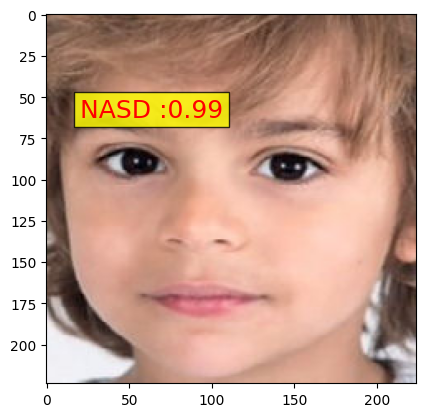

In [ ]:
#Prediction of image
%matplotlib inline
import tensorflow
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import numpy as np
img1 = image.load_img('/content/drive/MyDrive/ASD_v4-20250417T093020Z-001/ASD_v4/test/Non_Autistic/tna.003.jpg', target_size=(224, 224))
img = image.img_to_array(img1)
img = img/255
# create a batch of size 1 [N,H,W,C]
img = np.expand_dims(img, axis=0)
prediction = model.predict(img, batch_size=None,steps=1) #gives all class prob.
if(prediction[:,:]>0.5):
    value ='NASD :%1.2f'%(prediction[0,0])
    plt.text(20, 62,value,color='red',fontsize=18,bbox=dict(facecolor='yellow',alpha=0.8))
else:
    value ='ASD :%1.2f'%(1.0-prediction[0,0])
    plt.text(20, 62,value,color='red',fontsize=18,horizontalalignment='right',
        verticalalignment='bottom',bbox=dict(facecolor='yellow',alpha=0.8))

plt.imshow(img1)
plt.show()

In [ ]:
# === ANN PREDICTION BLOCK ===
import pandas as pd
import joblib

# Load ANN model and supporting tools
ann_model = load_model('/content/autism_model.h5')
scaler = joblib.load('/content/scaler.pkl')
t_int_encodings = joblib.load('/content/t_int_encodings.pkl')

# Sample input
new_sample = {
    'A1_Score': 0, 'A2_Score': 0, 'A3_Score': 0, 'A4_Score': 0, 'A5_Score': 0,
    'A6_Score': 0, 'A7_Score': 0, 'A8_Score': 0, 'A9_Score': 0, 'A10_Score': 0,
    'age': 5, 'gender': 'male', 'ethnicity': 'White-European',
    'jundice': 'no', 'contry_of_res': 'United States',
    'used_app_before': 'no', 'result': 10,
    'relation': 'Parent'
}

# Create DataFrame
new_df = pd.DataFrame([new_sample])
categorical_cols = ['gender', 'ethnicity', 'jundice', 'contry_of_res', 'used_app_before', 'relation']

# Encode categoricals using saved mapping
for col in categorical_cols:
    new_df[col] = new_df[col].astype(str).str.strip()
    new_df[col] = new_df[col].map(t_int_encodings[col])
    if new_df[col].isna().any():
        new_df[col] = new_df[col].fillna(t_int_encodings[col].mean())

# Safe scaling
X_scaled = scaler.transform(new_df)

# Predict with ANN
ann_pred = ann_model.predict(X_scaled)
ann_prob = float(ann_pred[0][0])
ann_class = "ASD" if ann_prob > 0.5 else "NASD"

print("ANN Prediction Class:", ann_class)
print("ANN Probability Score:", ann_prob)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
ANN Prediction Class: NASD
ANN Probability Score: 0.004447379149496555


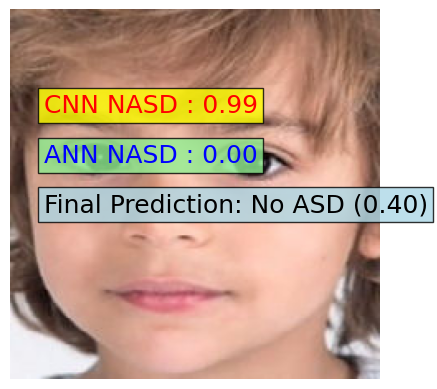

In [ ]:
# === FINAL COMBINED DECISION BLOCK ===

# Ensure cnn_class and ann_class are already computed
# cnn_class from image CNN
cnn_prob = float(prediction[0][0])
cnn_class = "NASD" if cnn_prob > 0.5 else "ASD"
cnn_asd_prob = 1.0 - cnn_prob if cnn_class == "NASD" else cnn_prob

# ann_class and ann_prob are already computed from ANN block
ann_asd_prob = 1.0 - ann_prob if ann_class == "NASD" else ann_prob

# Weighted average for final combined prediction
final_prob = (0.6 * cnn_asd_prob + 0.4 * ann_asd_prob)
final_class = "ASD" if final_prob >= 0.5 else "No ASD"

# === DISPLAY ===
# CNN Prediction Display
cnn_value = f'CNN {cnn_class} : {cnn_prob:.2f}' if cnn_class == "NASD" else f'CNN {cnn_class} : {cnn_prob:.2f}'
plt.text(20, 62, cnn_value, color='red', fontsize=18, bbox=dict(facecolor='yellow', alpha=0.8))

# ANN Prediction Display
ann_value = f'ANN {ann_class} : {ann_prob:.2f}'
plt.text(20, 92, ann_value, color='blue', fontsize=18, bbox=dict(facecolor='lightgreen', alpha=0.8))

# Final Prediction Display
plt.text(20, 122, f"Final Prediction: {final_class} ({final_prob:.2f})", color='black', fontsize=18, bbox=dict(facecolor='lightblue', alpha=0.8))

# Show image
plt.imshow(img1)
plt.axis('off')
plt.show()
